In [1]:
using DomDecOT
using MultiScaleOT
import MultiScaleOT: normalize!
using MAT
using Plots
using SparseArrays
default(size = (400, 400), legend = :none, aspect_ratio = :equal, showaxis = false)
import Logging

In [2]:
# Loading data
path = "data/"
fn1 = "g-008-2048.mat"
fn2 = "g-009-2048.mat"
d1 = matread(path*fn1)
shapeX = size(d1["a"])
μ = d1["a"]
N1 = 2^11
N2 = 2^8
μ = reshape(μ, N1÷N2, N2, N1÷N2, N2)
μ = sum(μ, dims = (1,3))
μ = reshape(μ, N2, N2)
shapeX = size(μ)
μ = μ[:]
normalize!(μ)
x1 = collect(1:N2)
X = flat_grid(x1, x1)

d2 = matread(path*fn2)
ν = d2["a"]
ν = reshape(ν, N1÷N2, N2, N1÷N2, N2)
ν = sum(ν, dims = (1,3))
ν = reshape(ν, N2, N2)
shapeY = size(ν)
ν = ν[:]
normalize!(ν)
y1 = collect(1:N2)
Y = flat_grid(y1, y1)

mu = GridMeasure(X, μ, shapeX)
nu = GridMeasure(Y, ν, shapeY)
mu, nu

(2D GridMeasure with gridshape (256, 256), 2D GridMeasure with gridshape (256, 256))

In [3]:
muH = MultiScaleMeasure(mu)
nuH = MultiScaleMeasure(nu)

MultiScaleMeasure with depth 9.
Finest level given by 2D GridMeasure with gridshape (256, 256)

In [4]:
# Set up parameters
println("Setting up parameters")

depth = muH.depth

# Epsilon schedule
Nsteps = 3
factor = 2.
eps_target = 0.5
last_iter = [eps_target/2]

# Epsilon scaling
eps_schedule = scaling_schedule(depth, eps_target, Nsteps, factor; last_iter = last_iter)

layer_schedule = template_schedule(depth, [1,1,1], collect(1:depth); last_iter = [depth])

layer_Nsteps = template_schedule(depth, [4, 2, 2], ones(Int, depth); last_iter = [2])

# Explain params_schedule, why named tuples are efficient
params_schedule = make_schedule(
                    layer = layer_schedule,
                    epsilon = eps_schedule, 
                    solver_max_error = 1e-4,
                    solver_max_error_rel=true, 
                    solver_max_iter = 10000, 
                    solver_verbose = true,
                    balance = true,
                    truncate = true,
                    truncate_Ythresh = 1e-15, 
                    truncate_Ythresh_rel = false, 
                    parallel_iteration = true,
                    iters = layer_Nsteps
            );

params_schedule[end]

Setting up parameters


(epsilon = 0.25, solver_max_error = 0.0001, solver_max_error_rel = true, solver_max_iter = 10000, solver_verbose = true, solver_truncation = 1.0e-15, layer = 9, balance = true, truncate = true, truncate_Ythresh = 1.0e-15, truncate_Ythresh_rel = false, parallel_iteration = true, iters = 2)

In [5]:
# Initialization parameters
layer0 = 4

mu0 = muH[layer0]
nu0 = nuH[layer0]

cellsize = 4

K0 = sparse(nu0.weights .* mu0.weights')

# Explain l22
c(x,y) = l22(x,y)
solver = DomDecOT.domdec_sinkhorn_autofix!

# First 
k0 = findfirst(params_schedule.layer .== layer0)
P0 = DomDecPlan(mu0, nu0, K0, cellsize)


DomDecPlan with cellsize 4 and marginals
    mu: 2D GridMeasure with gridshape (8, 8)
    nu: 2D GridMeasure with gridshape (8, 8)

In [6]:

save_plans = true
compute_PD_gap = true

# precompile iterate! and refine_plan
P = deepcopy(P0)
iterate!(P, c, solver, params_schedule[k0])
P = refine_plan(P0, muH, nuH, layer0+1; consistency_check = false)

DomDecPlan with cellsize 4 and marginals
    mu: 2D GridMeasure with gridshape (16, 16)
    nu: 2D GridMeasure with gridshape (16, 16)

In [7]:
P = deepcopy(P0)
if compute_PD_gap
    println("Layer\tepsilon\ttime\tRelative PD gap")
else
    println("Layer\tepsilon\ttime")
end

if save_plans 
    plans = []
end

times = Dict(:solve => 0.0, :refine => 0.0)
for k in k0:length(params_schedule)
    # Get parameters
    params = params_schedule[k]
    i = params.layer

    t0 = time()
    iterate!(P, c, solver, params)
    times[:solve] += time() - t0
    print(i,"\t",params.epsilon,"\t",round(times[:solve]+times[:refine], digits = 2))
    
    if compute_PD_gap
        gap = let 
            K = plan_to_sparse_matrix(P, c)
            a, b = smooth_alpha_and_beta_fields(P, c)
            score1 = primal_score_sparse(K, c, P.nu, P.mu, P.epsilon)
            score2 = dual_score_sparse(b, a, c, P.nu, P.mu, P.epsilon, K)
            gap = (score1-score2)/score1
        end
        print("\t", gap)
    end
    println()
    # Refine
    if save_plans
        push!(plans, (i, k, deepcopy(P)))
    end
    if (i < depth) && (i != params_schedule.layer[k+1])
        
        t0 = time()
        global P = refine_plan(P, muH, nuH, i+1; consistency_check = false)
        times[:refine] += time() - t0
        println("   Refinement\t",round(times[:solve]+times[:refine], digits = 2))
    end
end
if save_plans
    #push!(plans, deepcopy(P))
end

Layer	epsilon	time	Relative PD gap
4	2048.0	0.02	8.340019171791604e-9
4	1024.0	0.02	2.644670914969611e-5
4	512.0	0.03	6.6484968578076e-5
   Refinement	0.03
5	512.0	0.03	9.020487506275776e-5
5	256.0	0.04	0.0003926731995715967
5	128.0	0.05	0.0002470548466334862
   Refinement	0.05
6	128.0	0.11	5.999652132865409e-5
6	64.0	0.14	0.0002968637226494007
6	32.0	0.17	0.00015934393022871418
   Refinement	0.18
7	32.0	0.49	2.914889117650191e-5
7	16.0	0.59	0.0001256511514300596
7	8.0	0.68	6.933513269367988e-5
   Refinement	0.7
8	8.0	1.57	1.5605927719544548e-5
8	4.0	2.2	4.728102044207056e-5
8	2.0	2.58	3.386785714296033e-5
   Refinement	2.68
9	2.0	6.61	1.24465254342478e-5
9	1.0	8.49	2.3395746247956284e-5
9	0.5	9.89	2.37577091521636e-5
9	0.25	11.85	4.79029429348245e-5


# Check solution

In [16]:
K = plan_to_sparse_matrix(P, c)

l1(sum(K, dims = 1), muH[end].weights), l1(sum(K, dims = 2), nuH[end].weights)


(1.4321798855666432e-10, 1.3751700315545501e-10)

In [17]:
# Number of non-zero entries / non-zero entries in mu
sum(length.(getproperty.(P.gamma, :nzind)))/length(muH[end].weights)

3.2158203125

# Visualize plan

In [18]:
function distortion_map(P)
    A = zeros(prod(P.nu.gridshape))
    for J in P.composite_cells[1]
        for (i,j) in enumerate(J)
            νi = P.gamma[j]
            A[νi.nzind] .+= i.*νi.nzval
        end
    end
    A ./= P.nu.weights
    return reshape(A, P.nu.gridshape)
end

distortion_map (generic function with 1 method)

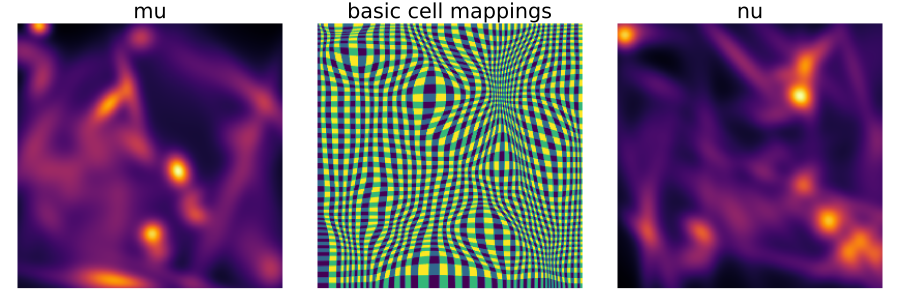

In [19]:
_, _, P = plans[end]
p1 = heatmap(reshape(muH[end].weights, muH[end].gridshape...),ticks = false, title = "mu")
p2 = heatmap(distortion_map(P), size = (400,400), color = :viridis, 
                title = "basic cell mappings", ticks = false)
p3 = heatmap(reshape(nuH[end].weights, nuH[end].gridshape...),ticks = false, title = "nu")
plot(p1, p2, p3, size = (900, 300), layout = (1,3))

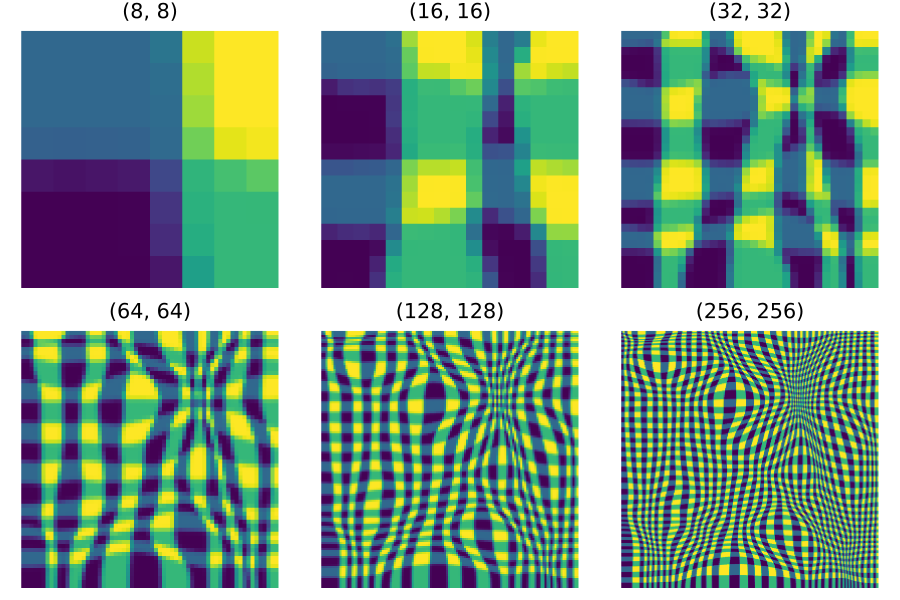

In [20]:
if save_plans
    plots = []
    for j in layer0:depth        
        j = findlast(x -> plans[x][1] == j, 1:length(plans))
        _, _, P = plans[j]
        pi = heatmap(distortion_map(P), size = (600,600), color = :viridis, 
                    title = "$(P.mu.gridshape)", ticks = false)
        push!(plots, pi)
    end
    plot(plots..., layout = (2, 3), size = (900, 600))
    #savefig("distortion_map.png")
end
plot!()

Plots.AnimatedGif("/home/ismael/PhD/DomDec/DomDecOT.jl/notebooks/refinement.gif")
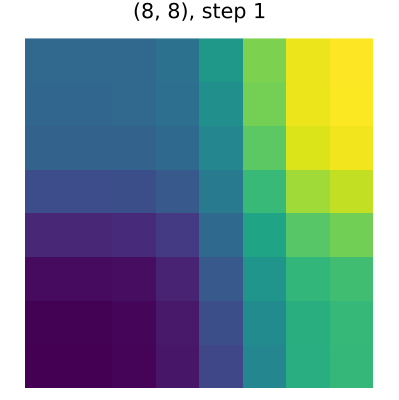

In [21]:
if save_plans
    anim = @animate for i in eachindex(plans)
        j,_, P = plans[i]
        k = i + 1 - findfirst(k->plans[k][1]==j, eachindex(plans))
        plot(
            #heatmap(reshape(muH[j].weights, muH[j].gridshape...),ticks = false, title = "mu"),
            heatmap(distortion_map(P), size = (400,400), color = :viridis, 
                title = "$(P.mu.gridshape), step $k", ticks = false),
            #heatmap(reshape(nuH[j].weights, nuH[j].gridshape...),ticks = false, title = "nu"),
            size = (400, 400), layout = (1,1)
        )
    end
    Logging.disable_logging(Logging.Info) # For privacy reasons
    g = gif(anim, "refinement.gif", fps = 1)
end